<a href="https://colab.research.google.com/github/mariecoolsaet/FLXLM/blob/master/SEP_728_Chatbot_transformer_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
print(tf.__version__)

2.7.0


Git Commands to clone repository, pull and push data

In [3]:
!git clone https://github.com/aanchal0431/chatbot.git
#!git pull
%cd chatbot/
#!git config --global user.name "aanchal0431"
#!git config --global user.email "aanchal0431@gmail.com"
#!git remote add aanchal0431 https://github.com/aanchal0431/chatbot.git
#!git --help
#!git remote -v
#!git init
#%ls
#!git add outputs/
!git status 
#!git commit -m 'Model epoch 1'


Cloning into 'chatbot'...
remote: Enumerating objects: 731, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 731 (delta 72), reused 179 (delta 35), pack-reused 486
Receiving objects: 100% (731/731), 7.99 MiB | 9.79 MiB/s, done.
Resolving deltas: 100% (119/119), done.
/content/chatbot
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Data Preprocessing - **Cleaning**

*   Load datasets
*   Append question and answer datasets
*   Remove questions with no answers
*   Drop irrelevant columns
*   Remove duplicate questions
*   Convert data to lower case
*   Add context

In [5]:
cur_path = 'Data/Question_Answer_Dataset_v1.2/'
data_s8 = pd.read_csv(cur_path + 'S08/question_answer_pairs.txt', delimiter="\t")
data_s9 = pd.read_csv(cur_path + 'S09/question_answer_pairs.txt', delimiter="\t")
data_s10 = pd.read_csv(cur_path + 'S10/question_answer_pairs.txt', delimiter="\t")
print("Shape s8:", data_s8.shape)
print("Shape s9:", data_s9.shape)
print("Shape s10:", data_s10.shape)
data_s8.head()

Shape s8: (1715, 6)
Shape s9: (825, 6)
Shape s10: (1458, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Append Data

In [6]:
#append all questions into one data set
data_all = data_s8.append(data_s9.append(data_s10))
print("Shape:", data_all.shape)
data_all.head()


Shape: (3998, 6)


,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


Drop irrelevant columns and remove questions without an answer

In [7]:
#remove irrelevant columns
data_all = data_all.drop(labels = ['DifficultyFromQuestioner', 'DifficultyFromAnswerer', 'ArticleFile'], axis = 1)

#drop rows with NULL values
data_all = data_all.dropna(subset=['Answer'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (3422, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Abraham_Lincoln,Did his mother die of pneumonia?,no


Remove duplicate questions

In [8]:
#remove duplicate questions
data_all = data_all.drop_duplicates(subset=['Question'])
print("Shape:", data_all.shape)
data_all.head()

Shape: (2203, 3)


,ArticleTitle,Question,Answer
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes
4,Abraham_Lincoln,Did his mother die of pneumonia?,no
6,Abraham_Lincoln,How many long was Lincoln's formal education?,18 months
8,Abraham_Lincoln,When did Lincoln begin his political career?,1832


Convert all text to lower case

In [9]:
# convert text to lower case
data_all = data_all.apply(lambda x: x.astype(str).str.lower())
data_all.head()

,ArticleTitle,Question,Answer
0,abraham_lincoln,was abraham lincoln the sixteenth president of...,yes
2,abraham_lincoln,did lincoln sign the national banking act of 1...,yes
4,abraham_lincoln,did his mother die of pneumonia?,no
6,abraham_lincoln,how many long was lincoln's formal education?,18 months
8,abraham_lincoln,when did lincoln begin his political career?,1832


Load Wikipedia article and add to the dataframe

In [10]:
#Add a column containing the context
#create dataset with column
title = []
context = []

#pull context and titles from S08
for y in range (8, 11):   
  for s in range(1, 7):
    for a in range(1, 11):
      file = str('Data/Question_Answer_Dataset_v1.2/S0' + str(y) + '/data/set' + str(s) + '/a' + str(a) + '.txt.clean' )
      if os.path.exists(file):
        article = open(file, encoding = "ISO-8859-1").read()
        context.append(article)
        title.append(article.split('\n')[0])

#create dataframe for context and titles
data_articles = pd.DataFrame({'ArticleTitle': title,
                              'Context': context})

#make lower case
data_articles = data_articles.apply(lambda x: x.astype(str).str.lower())

print("Shape:", data_articles.shape)
data_articles.head()

Shape: (90, 2)


,ArticleTitle,Context
0,kangaroo,kangaroo\n\n\na kangaroo is a marsupial from t...
1,leopard,leopard\n\n\n\nthe leopard (panthera pardus) i...
2,penguin,penguin\n\n\n\na penguin encounters a human du...
3,polar bear,polar bear\n\n\n\nthe polar bear (ursus mariti...
4,elephant,elephant\n\n\n\nelephants (elephantidae) are a...


In [11]:
#replace all _ in titles with spaces
data_all['ArticleTitle'] = data_all['ArticleTitle'].str.replace('_', ' ')
data_articles['ArticleTitle'] = data_articles['ArticleTitle'].str.replace('_', ' ')

#join context into data all
data_all = data_all.merge(data_articles, how='left', on='ArticleTitle')

print("Shape:", data_all.shape)
data_all.head()

Shape: (2755, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...


### Explore Data
Check the word length of the answers. How many questions are yes/no questions? What type of question is asked most often?

Single word answers: 1575
Two word answers: 231
Three word answers: 161
Four word answers: 124
Five word answers: 88
6-10 word answers: 341
11-20 word answers: 186
More than 20 words answers: 49

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

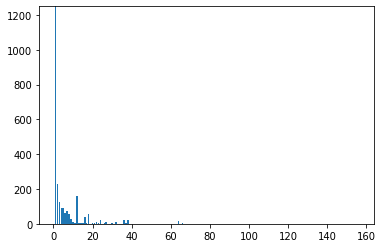

In [12]:
#plot the distribution of answer word length
word_length = data_all['Answer'].str.count(' ') + 1
string_length = data_all['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,1250])
plt.show

In [13]:
#examine types of questions
question_type = data_all['Question'].str.split(' ').str[0]
question_type.value_counts()

what                                 564
is                                   395
was                                  247
how                                  196
did                                  193
                                    ... 
on                                     1
oxygen                                 1
at                                     1
&#20415;&#24403;/&#20415;&#30070;      1
one-fifth                              1
Name: Question, Length: 102, dtype: int64

In [14]:
#pull all yes/no questions
yes_no = ['yes', 'yes.', 'yes,', 'no', 'no.', 'no,']
data_yn = data_all.where(data_all['Answer'].str.split(' ').str[0].isin(yes_no)).dropna()
data_yn['Answer'] = data_yn['Answer'].str.split(' ').str[0]

#remove periods & commas
data_yn['Answer'] = data_yn['Answer'].str.replace('.','')
data_yn['Answer'] = data_yn['Answer'].str.replace(',','')

print("Shape:", data_yn.shape)
data_yn.head()

Shape: (1070, 4)


,ArticleTitle,Question,Answer,Context
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...


In [15]:
#pull all other questions that pull "direct" answers from the context
data_context = data_all.where((data_all['Answer'].str.split(' ').str[0].isin(yes_no)) == False).dropna()
print("Shape:", data_context.shape)
data_context.head()

Shape: (1252, 4)


,ArticleTitle,Question,Answer,Context
3,abraham lincoln,how many long was lincoln's formal education?,18 months,abraham lincoln\n\n\n\nabraham lincoln (februa...
4,abraham lincoln,when did lincoln begin his political career?,1832,abraham lincoln\n\n\n\nabraham lincoln (februa...
5,abraham lincoln,what did the legal tender act of 1862 establish?,"the united states note, the first paper curren...",abraham lincoln\n\n\n\nabraham lincoln (februa...
6,abraham lincoln,who suggested lincoln grow a beard?,11-year-old grace bedell,abraham lincoln\n\n\n\nabraham lincoln (februa...
7,abraham lincoln,when did the gettysburg address argue that ame...,1776,abraham lincoln\n\n\n\nabraham lincoln (februa...


Single word answers: 363
Two word answers: 197
Three word answers: 141
Four word answers: 99
Five word answers: 69
6-10 word answers: 236
11-20 word answers: 116
More than 20 words answers: 31

Max answer word length: 156
Max answer string length: 926


<function matplotlib.pyplot.show>

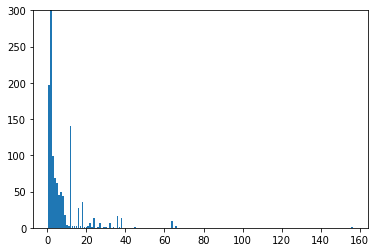

In [16]:
#plot the distribution of answer word length for questions that aren't yes/no
word_length = data_context['Answer'].str.count(' ') + 1
string_length = data_context['Answer'].str.len()

print('Single word answers:', (word_length == 1).sum())
print('Two word answers:', (word_length == 2).sum())
print('Three word answers:', (word_length == 3).sum())
print('Four word answers:', (word_length == 4).sum())
print('Five word answers:', (word_length == 5).sum())
print('6-10 word answers:', ((word_length > 5) & (word_length <= 10)).sum())
print('11-20 word answers:', ((word_length > 10) & (word_length <= 20)).sum())
print('More than 20 words answers:', (word_length > 20).sum())
print('\nMax answer word length:', word_length.max())
print('Max answer string length:', string_length.max())

#plt.hist(word_length, bins = 100)
plt.bar(word_length.unique(), word_length.value_counts())
plt.ylim([0,300])
plt.show

In [17]:
#create type indicator in data set and combine clean yes/no and context
data_yn['Answer Type'] = 'yes/no'
data_context['Answer Type'] = 'context'
data_all = data_yn.append(data_context)

print("Shape:", data_all.shape)
data_all.head()

Shape: (2322, 5)


,ArticleTitle,Question,Answer,Context,Answer Type
0,abraham lincoln,was abraham lincoln the sixteenth president of...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
1,abraham lincoln,did lincoln sign the national banking act of 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
2,abraham lincoln,did his mother die of pneumonia?,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
8,abraham lincoln,did lincoln beat john c. breckinridge in the 1...,yes,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no
9,abraham lincoln,was abraham lincoln the first president of the...,no,abraham lincoln\n\n\n\nabraham lincoln (februa...,yes/no


<function matplotlib.pyplot.show>

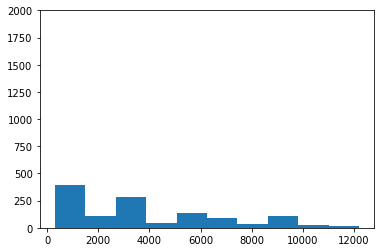

In [18]:
#plot the distribution of answer word length for questions that aren't yes/no
word_length = data_context['Context'].str.count(' ') + 1

plt.hist(word_length, bins = 10)
#plt.bar(word_length.unique(), word_length.value_counts())
#plt.bar(np.arange(90), word_length)
plt.ylim([0,2000])
plt.show

## Transformer (Context Questions)

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# segregating questions and answers into different lists
question = list(data_context['Question'])
answer = list(data_context['Answer'])
context = list((data_context['Context']))

input = list(map(lambda q, c: str(q + ' <SEP> ' + c), question, context))
output = list(map(lambda a: str('<START> ' + a + ' <END>'), answer))

In [21]:
#initialize the tokenizer
tokenizer = Tokenizer(oov_token="<oov>", char_level = False, lower = True) #oov: out of vocabulary token => used to handle newly encountered words in the training dataset, new

#creating word index
tokenizer.fit_on_texts(input + output)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

#create sequences using tokenizer
input_token = tokenizer.texts_to_sequences(input)
output_token = tokenizer.texts_to_sequences(output)

#padding the sequences to make sure length matches for all the sequences
padded_input_tokens = pad_sequences(input_token, padding='post', maxlen = 4000)
padded_output_tokens = pad_sequences(output_token , padding='post', maxlen = 4001)

print("Vocabulary size:", vocab_size)

max_input = padded_input_tokens.shape[1]
print("Max input length:", max_input)

#padded_output_tokens = pad_sequences(output_token , padding='post', maxlen=max_input + 1)

max_output = padded_output_tokens.shape[1]
print("Max answer length:", max_output)

print("Input token shape:", padded_input_tokens.shape)

Vocabulary size: 30655
Max input length: 4000
Max answer length: 4001
Input token shape: (1252, 4000)


In [30]:
# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(padded_input_tokens, padded_output_tokens,
          shuffle=True, test_size=0.1, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
          shuffle=True, test_size=0.2, random_state=5)

In [31]:
def format_dataset(input, answer):
  return ({"encoder_inputs": input, "decoder_inputs": answer[:, :-1],}, answer[:, 1:])

def make_dataset(X, y):
  dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  dataset = dataset.batch(batch_size=8)
  dataset = dataset.map(format_dataset)
  return dataset.shuffle(2048).prefetch(16).cache()
  
train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val)
test_ds = make_dataset(X_test, y_test)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (8, 4000)
inputs["decoder_inputs"].shape: (8, 4000)
targets.shape: (8, 4000)


In [27]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [ ]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(max_input, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(max_input, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

### Run first 10 epochs

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


#create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

epochs = 10

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 256)   3155456     ['positional_embedding_

In [ ]:
hist_all = pd.DataFrame(history.history)
hist_all["epoch"] = history.epoch
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')

### Run next 10 epochs

In [ ]:
# Load the previously saved weights
#latest = tf.train.latest_checkpoint(checkpoint_dir)
latest = '/content/drive/MyDrive/colab/chatbot/cp-0010.ckpt'

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

epochs = 10

# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
transformer.load_weights(latest)

#create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Keep training model
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
#update epoch metric history
hist_all = pd.read_csv('/content/drive/MyDrive/colab/chatbot/hist.csv', index_col = 0)
hist_run = pd.DataFrame(history.history)
hist_run['epoch'] = history.epoch

offset = 10
hist_run["epoch"] = list(map(lambda x: x + offset, history.epoch)) #adjust offset as needed

hist_all = hist_all.append(hist_run)
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')
hist_all.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.012451,0.271972,0.010575,0.303217,0
1,0.010662,0.307527,0.009766,0.327690,1
2,0.010040,0.319224,0.009293,0.333385,2
3,0.009403,0.347853,0.008506,0.363245,3
4,0.008688,0.383869,0.007864,0.405726,4


### Run 10 more

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
epochs = 10

# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
transformer.load_weights(latest)

#create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Keep training model
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
#update epoch metric history
hist_all = pd.read_csv('/content/drive/MyDrive/colab/chatbot/hist.csv', index_col = 0)
hist_run = pd.DataFrame(history.history)
hist_run['epoch'] = history.epoch

offset = 20
hist_run["epoch"] = list(map(lambda x: x + offset, history.epoch)) #adjust offset as needed

hist_all = hist_all.append(hist_run)
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')
hist_all.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.012451,0.271972,0.010575,0.303217,0
1,0.010662,0.307527,0.009766,0.327690,1
2,0.010040,0.319224,0.009293,0.333385,2
3,0.009403,0.347853,0.008506,0.363245,3
4,0.008688,0.383869,0.007864,0.405726,4


In [ ]:
hist_all = pd.read_csv('/content/drive/MyDrive/colab/chatbot/hist.csv', index_col = 0)

In [ ]:
corrected_epoch = []
for epoch in hist_all['epoch']:
  if epoch > 9:
    corrected_epoch.append(epoch + 4)
  else:
    corrected_epoch.append(epoch)
hist_all['corrected_epoch'] = corrected_epoch

(0.0, 0.02)

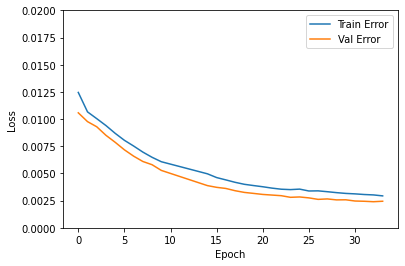

In [ ]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(hist_all['epoch'], hist_all['loss'], label='Train Error')
#plt.plot(hist_all['epoch'], hist_all['val_loss'], label='Val Error')
plt.plot(hist_all['corrected_epoch'], hist_all['loss'], label='Train Error')
plt.plot(hist_all['corrected_epoch'], hist_all['val_loss'], label='Val Error')
plt.legend()
plt.ylim([0,0.02])

### Run 10 More
34 - 44 epochs

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

latest = tf.train.latest_checkpoint(checkpoint_dir)
latest = '/content/drive/MyDrive/colab/chatbot/cp-0010.ckpt'
latest

'/content/drive/MyDrive/colab/chatbot/cp-0010.ckpt'

In [ ]:
epochs = 10

# Load the previously saved weights
transformer.load_weights(latest)

#create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Keep training model
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
#update epoch metric history
hist_all = pd.read_csv('/content/drive/MyDrive/colab/chatbot/hist.csv', index_col = 0)
hist_run = pd.DataFrame(history.history)
hist_run['epoch'] = history.epoch

offset = 20
hist_run["epoch"] = list(map(lambda x: x + offset, history.epoch)) #adjust offset as needed

hist_all = hist_all.append(hist_run)
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')
hist_all.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.012451,0.271972,0.010575,0.303217,0
1,0.010662,0.307527,0.009766,0.327690,1
2,0.010040,0.319224,0.009293,0.333385,2
3,0.009403,0.347853,0.008506,0.363245,3
4,0.008688,0.383869,0.007864,0.405726,4


In [ ]:
hist_all = pd.read_csv('/content/drive/MyDrive/colab/chatbot/hist.csv', index_col = 0)
epoch = np.arange(40)
hist_all['epoch'] = epoch
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')

In [ ]:
corrected_epoch = []
for epoch in hist_all['epoch']:
  if epoch > 9:
    corrected_epoch.append(epoch + 4)
  else:
    corrected_epoch.append(epoch)
hist_all['corrected_epoch'] = corrected_epoch

(0.0, 0.02)

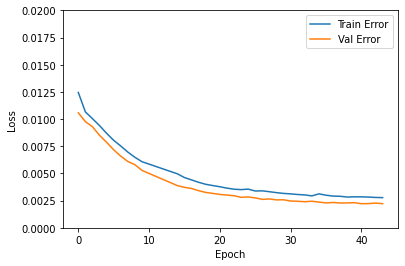

In [ ]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(hist_all['epoch'], hist_all['loss'], label='Train Error')
#plt.plot(hist_all['epoch'], hist_all['val_loss'], label='Val Error')
plt.plot(hist_all['corrected_epoch'], hist_all['loss'], label='Train Error')
plt.plot(hist_all['corrected_epoch'], hist_all['val_loss'], label='Val Error')
plt.legend()
plt.ylim([0,0.02])

### Run 10 more (41 - 50)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

epochs = 10

# Load the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)
transformer.load_weights(latest)

#create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Keep training model
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
#update epoch metric history
hist_all = pd.read_csv('/content/drive/MyDrive/colab/chatbot/hist.csv', index_col = 0)
hist_run = pd.DataFrame(history.history)
hist_run['epoch'] = history.epoch

offset = 40
hist_run["epoch"] = list(map(lambda x: x + offset, history.epoch)) #adjust offset as needed

hist_all = hist_all.append(hist_run)
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/hist.csv')
hist_all.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.012451,0.271972,0.010575,0.303217,0
1,0.010662,0.307527,0.009766,0.327690,1
2,0.010040,0.319224,0.009293,0.333385,2
3,0.009403,0.347853,0.008506,0.363245,3
4,0.008688,0.383869,0.007864,0.405726,4


In [ ]:
corrected_epoch = []
for epoch in hist_all['epoch']:
  if epoch > 9:
    corrected_epoch.append(epoch + 4)
  else:
    corrected_epoch.append(epoch)
hist_all['corrected_epoch'] = corrected_epoch

(0.0, 0.02)

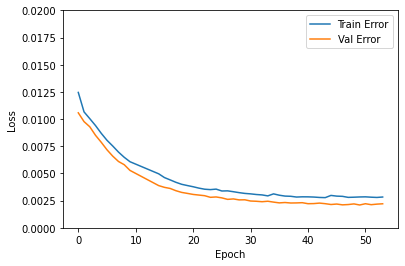

In [ ]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(hist_all['epoch'], hist_all['loss'], label='Train Error')
#plt.plot(hist_all['epoch'], hist_all['val_loss'], label='Val Error')
plt.plot(hist_all['corrected_epoch'], hist_all['loss'], label='Train Error')
plt.plot(hist_all['corrected_epoch'], hist_all['val_loss'], label='Val Error')
plt.legend()
plt.ylim([0,0.02])

## Evaluate

In [ ]:
# Load the best weights
best = '/content/drive/MyDrive/colab/chatbot/cp-0001.ckpt'
transformer.load_weights(best)

In [ ]:
transformer.evaluate(test_ds)

113/113 [==============================] - 1381s 12s/step - loss: 0.0021 - accuracy: 0.8807


[0.002143032616004348, 0.8807141780853271]

## Inference

In [ ]:
word_lookup = list(word_index.keys())
word_lookup.insert(0,'0')
print(word_lookup)

['0', '<oov>', 'the', 'of', 'and', 'in', 'a', 'to', 'is', 'as', 'was', 'by', 'for', 'on', 'that', 'with', 'are', 'his', 'he', 'from', 'it', 'at', 'an', 'or', 'which', 'have', 'this', 'be', 'their', 'also', 'not', 'has', 'one', 'other', 'its', 'but', 'most', 'were', 'had', 'some', 'they', 'tesla', 'first', 'more', 'been', 'new', 'two', 'many', 'than', 'after', 'such', 'all', 'there', 'turtles', 'into', 'when', 'used', 'time', 'can', 'these', 'years', 'only', 'world', 'between', 'president', 'known', 'may', 'war', 'who', 'during', 'made', 'about', 'species', 'would', 'national', '1', 'over', 'up', 'while', 'states', 'city', 'government', 'singapore', 'chinese', 'state', 'called', 'use', 'well', 'him', 'faraday', 'them', 'no', 'university', 'however', 'both', 'often', 'language', 'united', '000', 'where', 'american', 'later', 'like', 'three', 'modern', 'lincoln', 'large', 'newton', '2', 'population', 'grant', 'out', 'john', 'through', 'became', 'century', 'i', 'will', '4', 's', 'around', 

In [ ]:
# divide into train and test
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(data_context[['Question', 'Context']], data_context['Answer'],
          shuffle=True, test_size=0.1, random_state=5)
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(X_train_text, y_train_text,
          shuffle=True, test_size=0.2, random_state=5)

In [ ]:
max_decoded_sentence_length = 300

def decode_sequence(input_text):
    tokenized_input = tokenizer.texts_to_sequences(tf.nest.flatten(input_text))
    tokenized_input = pad_sequences(tokenized_input , padding='post', maxlen = 4000)

    decoded_sentence = "start"
    output_answer = ""
    tokenized_target_sentence = tokenizer.texts_to_sequences([decoded_sentence])
    tokenized_target_sentence = pad_sequences(tokenized_target_sentence , padding='post', maxlen = 4001)[:,:-1]
    
    for i in range(max_decoded_sentence_length):
        predictions = transformer.predict([tokenized_input, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = word_lookup[sampled_token_index]

        if sampled_token == "end":
            break

        decoded_sentence += " " + sampled_token
        output_answer += " " + sampled_token
        tokenized_target_sentence = tokenizer.texts_to_sequences([decoded_sentence])
        tokenized_target_sentence = pad_sequences(tokenized_target_sentence , padding='post', maxlen = 4001)[:, :-1]
  
        
    return output_answer

In [ ]:
import random

In [ ]:
#inference on Training Questions
for _ in range(30):
  i = random.choice(range(X_train_text.shape[0]))
  input_text = str(X_train_text['Question'].tolist()[i] + ' <SEP> ' + X_train_text['Context'].tolist()[i])
  bot_answer = decode_sequence(input_text)

  print('\nQuestion:', X_train_text['Question'].tolist()[i])
  print('Bot Answer:', bot_answer)
  print('Actual Answer:', y_train_text.tolist()[i])


Question: where is the park of the reserve located?
Bot Answer:  the city lima
Actual Answer: near the downtown area.

Question: what is an otter's den called?
Bot Answer:  the battery made by volta is credited as the first electrochemical cell
Actual Answer: holt

Question: what is the first number on the page?
Bot Answer:  monroe was elected president
Actual Answer: 28

Question: what happened in 1757 to 1759?
Bot Answer:  the definition of the electrostatic force of attraction and repulsion
Actual Answer: charles-augustin de coulomb joined his father's family in montpellier and took part in the work of the academy of the city.

Question: what happened in 1745?
Bot Answer:  the scale was reversed
Actual Answer: the scale was reversed

Question: an otter 's den is what?
Bot Answer:  a holt
Actual Answer: a holt

Question: which ballet by pyotr tchaikovsky is partially based on an ancient german legend about a princess who was turned into a swan?
Bot Answer:  monroe hill on the ground

In [ ]:
#inference on Test Questions
for _ in range(30):
  i = random.choice(range(X_test_text.shape[0]))
  input_text = str(X_test_text['Question'].tolist()[i] + ' <SEP> ' + X_test_text['Context'].tolist()[i])
  bot_answer = decode_sequence(input_text)

  print('\nQuestion:', X_test_text['Question'].tolist()[i])
  print('Bot Answer:', bot_answer)
  print('Actual Answer:', y_test_text.tolist()[i])


Question: what centred in sierra?
Bot Answer:  a flute can be an open tube which is the university and the city
Actual Answer: the leopard men

Question: what is the middle pedal called on grand pianos?
Bot Answer:  the the smithsonian museum
Actual Answer: the sostenuto pedal.

Question: where is old ghana in relation to present ghana?
Bot Answer:  at the battle of trenton in his left shoulder
Actual Answer: 500 miles north

Question: whom are guitars made and repaired by?
Bot Answer: 
Actual Answer: luthiers

Question: oxygen is what?
Bot Answer:  the
Actual Answer: one kind of gas obtained via a tracheal system.

Question: what animals are related to otters?
Bot Answer:  the time of year associated with this is also associated with the aquarius sign of the zodiac through which the sun passes january 20 february 19
Actual Answer: weasels, polecats, and badgers

Question: what is the origin of the name santiago?
Bot Answer:  the definition of the electrostatic force of attraction and

### Ask the Bot!

In [ ]:
context_dict = data_context.set_index('ArticleTitle')['Context'].to_dict()
topic_options = data_context['ArticleTitle'].unique().tolist()
print(topic_options)

['abraham lincoln', 'amedeo avogadro', 'anders celsius', 'beetle', 'calvin coolidge', 'canada', 'duck', 'egypt', 'elephant', 'finland', 'gerald ford', 'ghana', 'gray wolf', 'grover cleveland', 'henri becquerel', 'indonesia', 'james monroe', 'james watt', 'john adams', 'kangaroo', 'leopard', 'liechtenstein', 'millard fillmore', 'nikola tesla', 'otter', 'penguin', 'polar bear', 'qatar', 'romania', 'singapore', 'theodore roosevelt', 'turtle', 'ulysses s. grant', 'uruguay', 'woodrow wilson', 'alessandro volta', 'arabic language', 'bee', 'beijing', 'blaise pascal', 'cello', 'charles-augustin de coulomb', 'chinese language', 'copenhagen', 'cymbal', 'dhaka', 'english language', 'flute', 'fox', 'french language', 'german language', 'giraffe', 'isaac newton', 'lima', 'london', 'lyre', 'michael faraday', 'nassau', 'ottawa', 'santiago', 'swan', 'tiger', 'trumpet', 'violin', 'xylophone', 'drum', 'guitar', 'piano', 'swahili language', 'vietnamese language']


In [ ]:
print('Bot: What topic do you have a question about?')
topic = input()

if topic not in topic_options:
  print("Bot: I don't know anything about that.")
else:
  user_question = input("Bot: What is your question?\n")

input_text = str(user_question + ' <SEP> ' + context_dict.get(topic))
bot_answer = decode_sequence(input_text)

print('Bot:', bot_answer)


Bot: What topic do you have a question about?
abraham lincoln
Bot: What is your question?
How old is he?
Bot:  to free slaves


## Yes/No Question Answering

In [22]:
# segregating questions and answers into different lists
question = list(data_yn['Question'])
answer = list(data_yn['Answer'])
context = list((data_yn['Context']))

input = list(map(lambda q, c: str(q + ' <SEP> ' + c), question, context))
output = list(map(lambda a: str('<START> ' + a + ' <END>'), answer))

In [23]:
#create sequences using tokenizer from original model
input_token = tokenizer.texts_to_sequences(input)
output_token = tokenizer.texts_to_sequences(output)

#padding the sequences to make sure length matches for all the sequences
padded_input_tokens = pad_sequences(input_token, padding='post', maxlen = 4000)
padded_output_tokens = pad_sequences(output_token , padding='post', maxlen = 4001)

print("Vocabulary size:", vocab_size)

max_input = padded_input_tokens.shape[1]
print("Max input length:", max_input)

max_output = padded_output_tokens.shape[1]
print("Max answer length:", max_output)

print("Input token shape:", padded_input_tokens.shape)

Vocabulary size: 30655
Max input length: 4000
Max answer length: 4001
Input token shape: (1070, 4000)


In [24]:
# divide into train and test
X_train, X_test, y_train, y_test = train_test_split(padded_input_tokens, padded_output_tokens,
          shuffle=True, test_size=0.1, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
          shuffle=True, test_size=0.2, random_state=5)

In [ ]:
def format_dataset(input, answer):
  return ({"encoder_inputs": input, "decoder_inputs": answer[:, :-1],}, answer[:, 1:])

def make_dataset(X, y):
  dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  dataset = dataset.batch(batch_size=8)
  dataset = dataset.map(format_dataset)
  return dataset.shuffle(2048).prefetch(16).cache()
  
train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val)
test_ds = make_dataset(X_test, y_test)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (8, 4000)
inputs["decoder_inputs"].shape: (8, 4000)
targets.shape: (8, 4000)


### Evaluate with Trained Tansformer

In [ ]:
# Load the best weights
best = '/content/drive/MyDrive/colab/chatbot/cp-0001.ckpt'
transformer.load_weights(best)
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.evaluate(test_ds)

97/97 [==============================] - 953s 10s/step - loss: 0.0036 - accuracy: 0.5892


[0.0036403238773345947, 0.5891774892807007]

### Fine tune

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/yes_no/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


#create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

epochs = 10


transformer.summary()
transformer.load_weights(best)
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_16 (Posit  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 ionalEmbedding)                                                                                  
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_8 (Transfo  (None, None, 256)   3155456     ['positional_embedding_

### Get "true" accuracy

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/yes_no/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Get the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)

#load weights and compile model
transformer.load_weights(latest)
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
#create word lookup
word_lookup = list(word_index.keys())
word_lookup.insert(0,'0')
print(word_lookup)

#divide into train and test
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(data_yn[['Question', 'Context']], data_yn['Answer'],
          shuffle=True, test_size=0.1, random_state=5)
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(X_train_text, y_train_text,
          shuffle=True, test_size=0.2, random_state=5)

#bot decoder
max_decoded_sentence_length = 300

def decode_sequence(input_text):
    tokenized_input = tokenizer.texts_to_sequences(tf.nest.flatten(input_text))
    tokenized_input = pad_sequences(tokenized_input , padding='post', maxlen = 4000)

    decoded_sentence = "start"
    output_answer = ""
    tokenized_target_sentence = tokenizer.texts_to_sequences([decoded_sentence])
    tokenized_target_sentence = pad_sequences(tokenized_target_sentence , padding='post', maxlen = 4001)[:,:-1]
    
    for i in range(max_decoded_sentence_length):
        predictions = transformer.predict([tokenized_input, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = word_lookup[sampled_token_index]

        if sampled_token == "end":
            break

        decoded_sentence += " " + sampled_token
        output_answer += "" + sampled_token
        tokenized_target_sentence = tokenizer.texts_to_sequences([decoded_sentence])
        tokenized_target_sentence = pad_sequences(tokenized_target_sentence , padding='post', maxlen = 4001)[:, :-1]
  
        
    return output_answer

['0', '<oov>', 'the', 'of', 'and', 'in', 'a', 'to', 'is', 'as', 'was', 'by', 'for', 'on', 'that', 'with', 'are', 'his', 'he', 'from', 'it', 'at', 'an', 'or', 'which', 'have', 'this', 'be', 'their', 'also', 'not', 'has', 'one', 'other', 'its', 'but', 'most', 'were', 'had', 'some', 'they', 'tesla', 'first', 'more', 'been', 'new', 'two', 'many', 'than', 'after', 'such', 'all', 'there', 'turtles', 'into', 'when', 'used', 'time', 'can', 'these', 'years', 'only', 'world', 'between', 'president', 'known', 'may', 'war', 'who', 'during', 'made', 'about', 'species', 'would', 'national', '1', 'over', 'up', 'while', 'states', 'city', 'government', 'singapore', 'chinese', 'state', 'called', 'use', 'well', 'him', 'faraday', 'them', 'no', 'university', 'however', 'both', 'often', 'language', 'united', '000', 'where', 'american', 'later', 'like', 'three', 'modern', 'lincoln', 'large', 'newton', '2', 'population', 'grant', 'out', 'john', 'through', 'became', 'century', 'i', 'will', '4', 's', 'around', 

In [ ]:
y_train_text.value_counts()

yes    619
no     151
Name: Answer, dtype: int64

In [ ]:
#Get accuracy
correct = 0
incorrect = 0
for i in range(X_val_text.shape[0]):
  input_text = str(X_val_text['Question'].tolist()[i] + ' <SEP> ' + X_val_text['Context'].tolist()[i])
  bot_answer = decode_sequence(input_text)
  print('Bot:', bot_answer)
  print('Real:', y_val_text.tolist()[i])

  if y_val_text.tolist()[i] == bot_answer:
    correct = correct + 1
  else:
    incorrect = incorrect + 1

  print('Accuracy:', correct / (incorrect + correct))

Bot: yes
Real: yes
Accuracy: 1.0
Bot: yes
Real: yes
Accuracy: 1.0
Bot: yes
Real: yes
Accuracy: 1.0
Bot: yes
Real: yes
Accuracy: 1.0
Bot: yes
Real: yes
Accuracy: 1.0
Bot: yes
Real: yes
Accuracy: 1.0
Bot: yes
Real: no
Accuracy: 0.8571428571428571
Bot: yes
Real: no
Accuracy: 0.75
Bot: yes
Real: yes
Accuracy: 0.7777777777777778
Bot: yes
Real: yes
Accuracy: 0.8
Bot: yes
Real: yes
Accuracy: 0.8181818181818182
Bot: yes
Real: yes
Accuracy: 0.8333333333333334
Bot: yes
Real: no
Accuracy: 0.7692307692307693
Bot: yes
Real: no
Accuracy: 0.7142857142857143
Bot: yes
Real: yes
Accuracy: 0.7333333333333333
Bot: yes
Real: yes
Accuracy: 0.75
Bot: yes
Real: yes
Accuracy: 0.7647058823529411
Bot: yes
Real: no
Accuracy: 0.7222222222222222
Bot: yes
Real: yes
Accuracy: 0.7368421052631579
Bot: yes
Real: yes
Accuracy: 0.75
Bot: yes
Real: yes
Accuracy: 0.7619047619047619
Bot: yes
Real: yes
Accuracy: 0.7727272727272727
Bot: yes
Real: no
Accuracy: 0.7391304347826086
Bot: yes
Real: yes
Accuracy: 0.75
Bot: yes
Real: 

In [ ]:
#Get "no" accuracy
#Get accuracy
correct = 0
incorrect = 0
for i in range(X_val_text.shape[0]):
  if y_val_text.tolist()[i] == 'no':
    input_text = str(X_val_text['Question'].tolist()[i] + ' <SEP> ' + X_val_text['Context'].tolist()[i])
    bot_answer = decode_sequence(input_text)
    print('Bot:', bot_answer)
    print('Real:', y_val_text.tolist()[i])

    if y_val_text.tolist()[i] == bot_answer:
      correct = correct + 1
    else:
      incorrect = incorrect + 1

    print('Accuracy:', correct / (incorrect + correct))

Bot: yes
Real: no
Accuracy: 0.0
Bot: yes
Real: no
Accuracy: 0.0
Bot: yes
Real: no
Accuracy: 0.0
Bot: yes
Real: no
Accuracy: 0.0
Bot: yes
Real: no
Accuracy: 0.0
Bot: yes
Real: no
Accuracy: 0.0
Bot: yes
Real: no
Accuracy: 0.0
Bot: yes
Real: no
Accuracy: 0.0
Bot: no
Real: no
Accuracy: 0.1111111111111111
Bot: yes
Real: no
Accuracy: 0.1
Bot: yes
Real: no
Accuracy: 0.09090909090909091
Bot: yes
Real: no
Accuracy: 0.08333333333333333
Bot: yes
Real: no
Accuracy: 0.07692307692307693
Bot: yes
Real: no
Accuracy: 0.07142857142857142
Bot: yes
Real: no
Accuracy: 0.06666666666666667
Bot: yes
Real: no
Accuracy: 0.0625
Bot: yes
Real: no
Accuracy: 0.058823529411764705
Bot: yes
Real: no
Accuracy: 0.05555555555555555
Bot: yes
Real: no
Accuracy: 0.05263157894736842
Bot: yes
Real: no
Accuracy: 0.05
Bot: yes
Real: no
Accuracy: 0.047619047619047616
Bot: yes
Real: no
Accuracy: 0.045454545454545456
Bot: yes
Real: no
Accuracy: 0.043478260869565216
Bot: yes
Real: no
Accuracy: 0.041666666666666664
Bot: yes
Real: no

### Run up to 20 more epochs

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/yes_no/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Get the previously saved weights
latest = tf.train.latest_checkpoint(checkpoint_dir)

#load weights and compile model
transformer.load_weights(latest)
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

epochs = 20

# Load the previously saved weights
transformer.load_weights(latest)

#create a callback that saves the model's weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Keep training model
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

transformer.save_weights(checkpoint_path.format(epoch=0))

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[cp_callback])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   8871680     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

In [ ]:
epoch = np.arange(28)
train_loss = [3.1375e-04, 1.6088e-04, 1.5321e-04, 1.6003e-04, 1.4789e-04, 1.4184e-04, 1.4410e-04, 1.3764e-04, 1.3777e-04, 1.3921e-04, 1.4629e-04, 1.4189e-04, 1.3406e-04, 1.3876e-04, 1.3631e-04, 1.9892e-04, 1.3515e-04, 1.4088e-04, 1.3025e-04, 1.3165e-04, 1.3050e-04, 1.2540e-04, 1.2879e-04, 1.2160e-04, 1.2268e-04, 1.2211e-04, 1.1890e-04, 1.2188e-04]
val_loss = [1.3529e-04, 1.3586e-04, 1.1826e-04, 1.1627e-04, 1.2098e-04, 1.1678e-04, 1.1517e-04, 1.1503e-04, 1.1640e-04, 1.1864e-04, 1.1009e-04, 1.2350e-04, 1.1565e-04, 1.1197e-04,  1.0743e-04, 1.1151e-04, 1.1792e-04, 1.1772e-04, 1.1403e-04, 1.1204e-04, 1.1152e-04, 1.1147e-04, 1.1141e-04, 1.2839e-04, 1.1187e-04, 1.2592e-04, 1.4179e-04, 1.1841e-04]

(0.0, 0.0004)

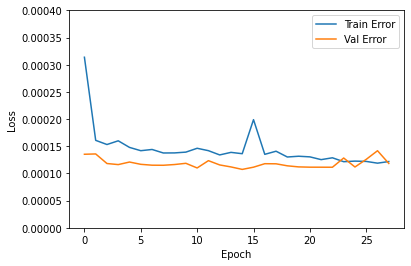

In [ ]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch, train_loss, label='Train Error')
plt.plot(epoch, val_loss, label='Val Error')
plt.legend()
plt.ylim([0,0.0004])

### Assess

In [ ]:
#use weights from 23rd epoch
best = '/content/drive/MyDrive/colab/chatbot/yes_no/cp-0013.ckpt'

#load weights and compile model
transformer.load_weights(best)
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


In [ ]:
#create word lookup
word_lookup = list(word_index.keys())
word_lookup.insert(0,'0')
print(word_lookup)

#divide into train and test
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(data_yn[['Question', 'Context']], data_yn['Answer'],
          shuffle=True, test_size=0.1, random_state=5)
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(X_train_text, y_train_text,
          shuffle=True, test_size=0.2, random_state=5)

#bot decoder
max_decoded_sentence_length = 300

def decode_sequence(input_text):
    tokenized_input = tokenizer.texts_to_sequences(tf.nest.flatten(input_text))
    tokenized_input = pad_sequences(tokenized_input , padding='post', maxlen = 4000)

    decoded_sentence = "start"
    output_answer = ""
    tokenized_target_sentence = tokenizer.texts_to_sequences([decoded_sentence])
    tokenized_target_sentence = pad_sequences(tokenized_target_sentence , padding='post', maxlen = 4001)[:,:-1]
    
    for i in range(max_decoded_sentence_length):
        predictions = transformer.predict([tokenized_input, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = word_lookup[sampled_token_index]

        if sampled_token == "end":
            break

        decoded_sentence += " " + sampled_token
        output_answer += "" + sampled_token
        tokenized_target_sentence = tokenizer.texts_to_sequences([decoded_sentence])
        tokenized_target_sentence = pad_sequences(tokenized_target_sentence , padding='post', maxlen = 4001)[:, :-1]
  
        
    return output_answer

['0', '<oov>', 'the', 'of', 'and', 'in', 'a', 'to', 'is', 'as', 'was', 'by', 'for', 'on', 'that', 'with', 'are', 'his', 'he', 'from', 'it', 'at', 'an', 'or', 'which', 'have', 'this', 'be', 'their', 'also', 'not', 'has', 'one', 'other', 'its', 'but', 'most', 'were', 'had', 'some', 'they', 'tesla', 'first', 'more', 'been', 'new', 'two', 'many', 'than', 'after', 'such', 'all', 'there', 'turtles', 'into', 'when', 'used', 'time', 'can', 'these', 'years', 'only', 'world', 'between', 'president', 'known', 'may', 'war', 'who', 'during', 'made', 'about', 'species', 'would', 'national', '1', 'over', 'up', 'while', 'states', 'city', 'government', 'singapore', 'chinese', 'state', 'called', 'use', 'well', 'him', 'faraday', 'them', 'no', 'university', 'however', 'both', 'often', 'language', 'united', '000', 'where', 'american', 'later', 'like', 'three', 'modern', 'lincoln', 'large', 'newton', '2', 'population', 'grant', 'out', 'john', 'through', 'became', 'century', 'i', 'will', '4', 's', 'around', 

Accuracy: 0.8051948051948052


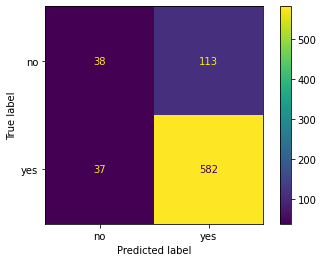

In [ ]:
#Evaluate train
correct = 0
incorrect = 0
y_pred = []
for i in range(X_train_text.shape[0]):
  input_text = str(X_train_text['Question'].tolist()[i] + ' <SEP> ' + X_train_text['Context'].tolist()[i])
  bot_answer = decode_sequence(input_text)
  y_pred.append(bot_answer)

  if y_train_text.tolist()[i] == bot_answer:
    correct = correct + 1
  else:
    incorrect = incorrect + 1

print('Accuracy:', correct / (incorrect + correct))
ConfusionMatrixDisplay.from_predictions(y_train_text, y_pred);

Accuracy: 0.7823834196891192


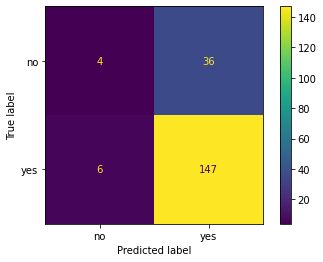

In [ ]:
#Evaluate validation
correct = 0
incorrect = 0
y_pred = []
for i in range(X_val_text.shape[0]):
  input_text = str(X_val_text['Question'].tolist()[i] + ' <SEP> ' + X_val_text['Context'].tolist()[i])
  bot_answer = decode_sequence(input_text)
  y_pred.append(bot_answer)

  if y_val_text.tolist()[i] == bot_answer:
    correct = correct + 1
  else:
    incorrect = incorrect + 1

print('Accuracy:', correct / (incorrect + correct))
ConfusionMatrixDisplay.from_predictions(y_val_text, y_pred);

Accuracy: 0.8411214953271028


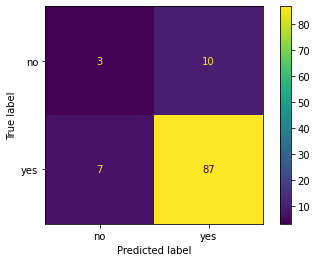

In [ ]:
#Evaluate test
correct = 0
incorrect = 0
y_pred = []
for i in range(X_test_text.shape[0]):
  input_text = str(X_test_text['Question'].tolist()[i] + ' <SEP> ' + X_test_text['Context'].tolist()[i])
  bot_answer = decode_sequence(input_text)
  y_pred.append(bot_answer)

  if y_test_text.tolist()[i] == bot_answer:
    correct = correct + 1
  else:
    incorrect = incorrect + 1

print('Accuracy:', correct / (incorrect + correct))
ConfusionMatrixDisplay.from_predictions(y_test_text, y_pred);

### Transfer Learning

In [25]:
y_train_binary = y_train[:,1] == 9016  #9016 = yes
y_val_binary = y_val[:,1] == 9016
y_test_binary = y_test[:,1] == 9016

In [28]:
#encoder model
embed_dim = 256
latent_dim = 2048
num_heads = 8

#encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(max_input, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

#load weights from context question training
encoder.load_weights('/content/drive/MyDrive/colab/chatbot/cp-0010.ckpt')

In [35]:
#freeze weights of encoder
encoder.trainable = False

In [41]:
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, None)]           0         
                                                                 
 positional_embedding_4 (Pos  (None, None, 256)        8871680   
 itionalEmbedding)                                               
                                                                 
 transformer_encoder_4 (Tran  (None, None, 256)        3155456   
 sformerEncoder)                                                 
                                                                 
Total params: 12,027,136
Trainable params: 12,027,136
Non-trainable params: 0
_________________________________________________________________


In [30]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x=encoder(encoder_inputs, training=False)
#x=layers.Dense(256, activation='relu')(x)
#x=layers.Dropout(0.5)(x)
#x=layers.Dense(256, activation='relu')(x)
#x=layers.Dropout(0.5)(x)
#x=layers.Dense(256, activation='relu')(x)
#x=layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model_yn = keras.Model(encoder_inputs, outputs)

In [ ]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/yes_no_transfer/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


#create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

epochs = 10

model_yn.summary()
model_yn.compile(
    "rmsprop", loss="binary_crossentropy", metrics=["accuracy"]
)

model_yn.save_weights(checkpoint_path.format(epoch=0))

history = model_yn.fit(X_train, y_train_binary, epochs=epochs, validation_data=[X_val, y_val_binary], callbacks=[cp_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, None)]           0         
                                                                 
 model (Functional)          (None, None, 256)         12027136  
                                                                 
 dense_2 (Dense)             (None, None, 1)           257       
                                                                 
Total params: 12,027,393
Trainable params: 257
Non-trainable params: 12,027,136
_________________________________________________________________
Epoch 1/10


Transfer learn in two parts due to RAM constraings.

In [31]:
def encode(X):
  encoded = np.zeros((X.shape[0],X.shape[1],256))
  for i in range(X.shape[0]):
    encoded[i,:,:] = encoder.predict(X[i:i+1,:])
  return encoded


In [30]:
X_train_stage = encode(X_train)

In [32]:
X_val_stage = encode(X_val)

In [32]:
model_yn = keras.models.Sequential([

        keras.Input(shape=X_train_stage[1,:,:].shape),

        layers.Flatten(),

        layers.Dense(256), 
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(256), 
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(256), 
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(1),
        layers.Activation('sigmoid')
])

In [33]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/yes_no_transfer/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


#create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

epochs = 30

model_yn.summary()
model_yn.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),"accuracy"])

model_yn.save_weights(checkpoint_path.format(epoch=0))

history = model_yn.fit(X_train_stage, y_train_binary, epochs=epochs, validation_data=[X_val_stage, y_val_binary], callbacks=[cp_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024000)           0         
                                                                 
 dense_2 (Dense)             (None, 256)               262144256 
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [34]:
hist_all = pd.DataFrame(history.history)
hist_all["epoch"] = history.epoch
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/yes_no_transfer/hist.csv')

(0.0, 10.0)

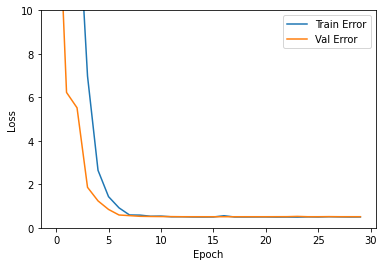

In [41]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_all['epoch'], hist_all['loss'], label='Train Error')
plt.plot(hist_all['epoch'], hist_all['val_loss'], label='Val Error')
plt.legend()
plt.ylim([0,10])

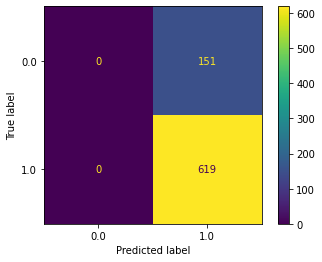

In [57]:
#Evaluate train
y_pred = model_yn.predict(X_train_stage)
ConfusionMatrixDisplay.from_predictions(y_train_binary*1., y_pred.round());

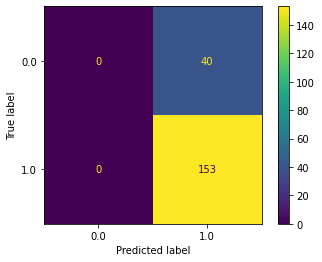

In [58]:
#Evaluate validation
y_pred = model_yn.predict(X_val_stage)
ConfusionMatrixDisplay.from_predictions(y_val_binary*1., y_pred.round());

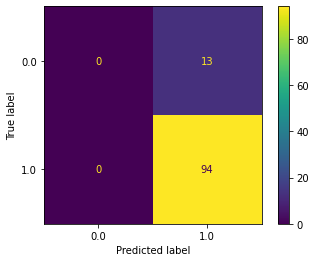

In [59]:
#Evaluate test
y_pred = model_yn.predict(encode(X_test))
ConfusionMatrixDisplay.from_predictions(y_test_binary*1., y_pred.round());

In [29]:
#balance training classes
X_train_pos = X_train[y_train_binary == 1]
y_train_pos = y_train_binary[y_train_binary == 1]
X_train_neg = X_train[y_train_binary == 0]
y_train_neg = y_train_binary[y_train_binary == 0]


X_train_pos, _, y_train_pos, _ = train_test_split(X_train_pos, y_train_pos,
          shuffle=True, train_size=X_train_neg.shape[0], random_state=5)
X_train_balanced = np.concatenate((X_train_pos, X_train_neg), axis=0)
y_train_balanced = np.concatenate((y_train_pos, y_train_neg), axis=0)

#shuffle
from sklearn.utils import shuffle
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=0)

In [33]:
X_train_bal_stage = encode(X_train_balanced)

In [35]:
model_yn_weighted = keras.models.Sequential([

        keras.Input(shape=X_train_bal_stage[1,:,:].shape),

        layers.Flatten(),

        layers.Dense(256), 
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(256), 
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(256), 
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Dense(1),
        layers.Activation('sigmoid')
])

In [36]:
checkpoint_path = '/content/drive/MyDrive/colab/chatbot/yes_no_transfer2/cp-{epoch:04}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)


#create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

epochs = 30


model_yn_weighted.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),"accuracy"])
model_yn_weighted.summary()
model_yn_weighted.save_weights(checkpoint_path.format(epoch=0))

class_weights = {1:1., 0:4.}

history = model_yn_weighted.fit(X_train_bal_stage, y_train_balanced, epochs=epochs, validation_data=[X_val_stage, y_val_binary], callbacks=[cp_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024000)           0         
                                                                 
 dense_2 (Dense)             (None, 256)               262144256 
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [37]:
hist_all = pd.DataFrame(history.history)
hist_all["epoch"] = history.epoch
hist_all.to_csv('/content/drive/MyDrive/colab/chatbot/yes_no_transfer2/hist.csv')

(0.0, 10.0)

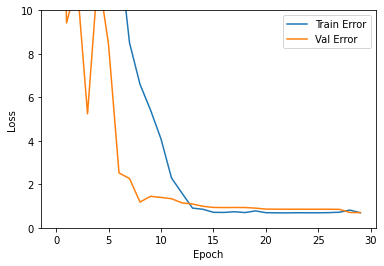

In [38]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist_all['epoch'], hist_all['loss'], label='Train Error')
plt.plot(hist_all['epoch'], hist_all['val_loss'], label='Val Error')
plt.legend()
plt.ylim([0,10])

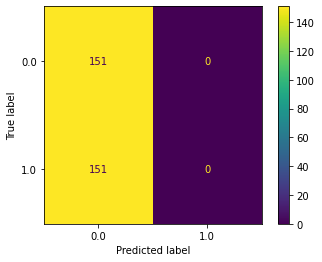

In [39]:
#Evaluate train
y_pred = model_yn_weighted.predict(X_train_bal_stage)
ConfusionMatrixDisplay.from_predictions(y_train_balanced*1., y_pred.round());

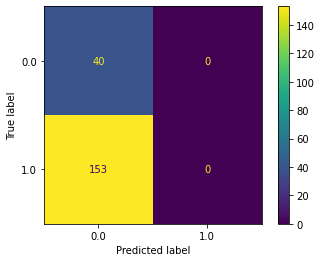

In [40]:
#Evaluate validation
y_pred = model_yn_weighted.predict(X_val_stage)
ConfusionMatrixDisplay.from_predictions(y_val_binary*1., y_pred.round());

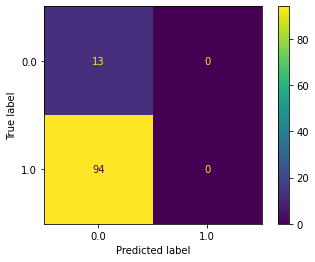

In [41]:
#Evaluate test
y_pred = model_yn_weighted.predict(encode(X_test))
ConfusionMatrixDisplay.from_predictions(y_test_binary*1., y_pred.round());